Classification using camera output images

Data Verification

In [1]:
import os

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
from PIL import Image # type: ignore

# Load the image
image = Image.open('/home/deepaksr/project/project_assignment1/data4/FLIR/Test/car/flir_20200116T174853.jpg')

# Get the mode of the image, which indicates the number of channels
print("Image mode:", image.mode)

# To get the number of channels directly
num_channels = len(image.getbands())
print("Number of channels:", num_channels)


Image mode: RGB
Number of channels: 3


In [58]:
import cv2 # type: ignore

# Load the image
image = cv2.imread('/home/deepaksr/project/project_assignment1/data4/FLIR/Test/car/flir_20200116T174853.jpg', -1)  # Load with all channels

# Get the shape of the image
print("Image shape:", image.shape)

# Number of channels is the last dimension
if len(image.shape) == 2:
    print("Number of channels: 1 (Grayscale)")
else:
    print(f"Number of channels: {image.shape[2]}")


Image shape: (1440, 1080, 3)
Number of channels: 3


In [59]:
train_path='/home/deepaksr/project/project_assignment1/data4/FLIR/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data4/FLIR/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.jpg'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: car
Images: 250

class: cat
Images: 272

class: man
Images: 289

Test Data:
class: car
Images: 147

class: cat
Images: 70

class: man
Images: 64



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [60]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [61]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.1)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 731 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 281 images belonging to 3 classes.
{'car': 0, 'cat': 1, 'man': 2}
731
{'car': 0, 'cat': 1, 'man': 2}
80
{'car': 0, 'cat': 1, 'man': 2}
281


Checking Shape of loaded data batches

In [62]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (8, 300, 300, 3), Labels shape: (8, 3)
Validation batch shape: (8, 300, 300, 3), Labels shape: (8, 3)
Test batch shape: (8, 300, 300, 3), Labels shape: (8, 3)


Define the CNN using MobileNet Backbone

In [18]:
from tensorflow.keras.applications import MobileNet # type: ignore
from tensorflow.keras.models import Model # type: ignore # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model_mobilenet(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Load MobileNet pretrained model
    conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freezing layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding layers on top
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(3, activation='softmax')(top_model)
    
    # Final model
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Re-compile the model, with last 15 layers unfrozen for Fine-Tuning
model = create_model_mobilenet((300,300,3), 3, optimizer=Adam(), fine_tune=15)

# Print model summary
model.summary()


/tmp/ipykernel_1213627/1533827763.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 150, 150, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 150, 150, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 151, 151, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 75, 75, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 75, 75, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 75, 75, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 75, 75, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 45,698,243 (174.32 MB)

 Trainable params: 44,064,259 (168.09 MB)

 Non-trainable params: 1,633,984 (6.23 MB)

In [19]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728270039.289908 1215481 service.cc:146] XLA service 0x7f2f3c02bea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728270039.290170 1215481 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-10-07 08:30:39.451244: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-07 08:30:40.081172: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907

 1/92 ━━━━━━━━━━━━━━━━━━━━ 18:40 12s/step - accuracy: 0.0000e+00 - loss: 1.9624

I0000 00:00:1728270044.866890 1215481 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 9/92 ━━━━━━━━━━━━━━━━━━━━ 22s 274ms/step - accuracy: 0.4370 - loss: 19.2291

E0000 00:00:1728270048.392960 1215480 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728270048.515348 1215480 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


10/92 ━━━━━━━━━━━━━━━━━━━━ 1:06 807ms/step - accuracy: 0.4533 - loss: 20.1838

2024-10-07 08:30:52.099166: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 8 bytes spill stores, 8 bytes spill loads



92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 363ms/step - accuracy: 0.7575 - loss: 17.9384 - val_accuracy: 0.8875 - val_loss: 4.4824
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 291ms/step - accuracy: 0.9436 - loss: 3.9535 - val_accuracy: 0.7500 - val_loss: 20.3937
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 292ms/step - accuracy: 0.9846 - loss: 0.8513 - val_accuracy: 0.6625 - val_loss: 46.4675
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 0.9880 - loss: 0.7055 - val_accuracy: 0.6625 - val_loss: 52.2094
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 292ms/step - accuracy: 0.9715 - loss: 1.7744 - val_accuracy: 0.5250 - val_loss: 133.2428
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 290ms/step - accuracy: 0.9762 - loss: 1.4068 - val_accuracy: 0.6500 - val_loss: 71.0659
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 291ms/step - accuracy: 0.9878 - loss: 1.2990 - val_accuracy: 0.6875 - val_loss: 76.7025
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - accuracy: 0.9931 - loss: 0.6185 - val_accurac

In [20]:
history_dict = history.history

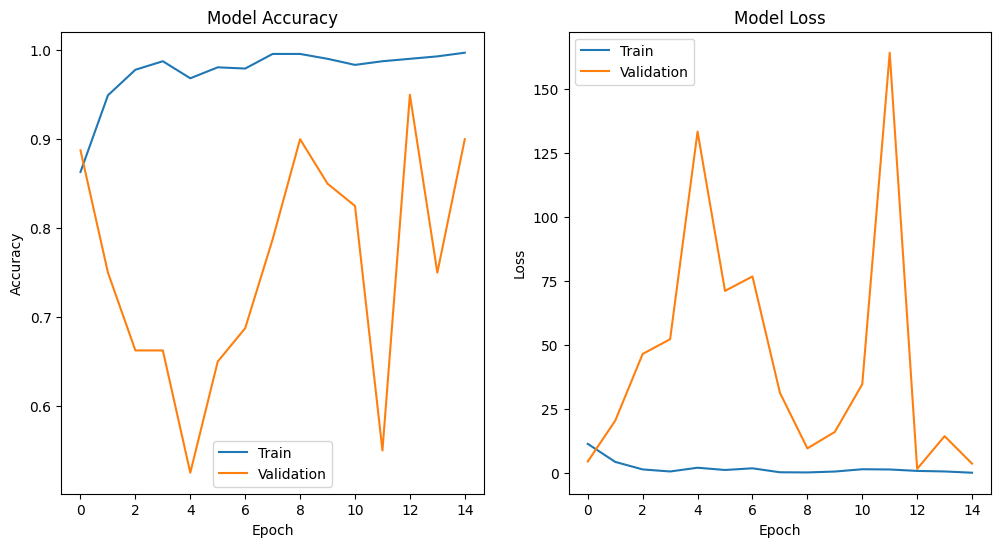

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [22]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step

E0000 00:00:1728270513.123082 1215485 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728270513.243998 1215485 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728270513.358417 1215485 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 340ms/step
[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [23]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9751
Precision : 0.9768
Recall : 0.9751
F1 Score : 0.9754
Classification Report:
               precision    recall  f1-score   support

         car       1.00      0.97      0.99       147
         cat       0.99      0.96      0.97        70
         man       0.91      1.00      0.96        64

    accuracy                           0.98       281
   macro avg       0.97      0.98      0.97       281
weighted avg       0.98      0.98      0.98       281



In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[143   1   3]
 [  0  67   3]
 [  0   0  64]]


Define the CNN using VGG16 Backbone

In [63]:
from keras.applications.vgg16 import VGG16, preprocess_input # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model_VGG(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Load VGG16 pretrained model
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freezing layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding layers on top
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(3, activation='softmax')(top_model)
    
    # Final model
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Re-compile the model, with last 15 layers unfrozen for Fine-Tuning
model = create_model_VGG((300,300,3), 3, optimizer=Adam(learning_rate=0.0001), fine_tune=15)

# Print model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,950,403 (137.14 MB)

 Trainable params: 35,911,683 (136.99 MB)

 Non-trainable params: 38,720 (151.25 KB)

In [64]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-07 09:57:38.620782: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 09:57:38.994456: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memor

54/92 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - accuracy: 0.4743 - loss: 1.1566

2024-10-07 09:58:00.125729: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 09:58:00.355547: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 09:58:00.620076: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 09:58:00.913706: W external/local_tsl/tsl/framework/bfc_

92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 381ms/step - accuracy: 0.5112 - loss: 1.0754 - val_accuracy: 0.5250 - val_loss: 0.8903
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 0.8365 - loss: 0.4599 - val_accuracy: 0.3625 - val_loss: 0.9852
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.8130 - loss: 0.4708 - val_accuracy: 0.8625 - val_loss: 0.4629
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.9025 - loss: 0.2815 - val_accuracy: 0.8125 - val_loss: 0.5068
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 305ms/step - accuracy: 0.9347 - loss: 0.2123 - val_accuracy: 0.8500 - val_loss: 0.4049
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 296ms/step - accuracy: 0.9367 - loss: 0.1865 - val_accuracy: 0.9000 - val_loss: 0.4360
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.9197 - loss: 0.2379 - val_accuracy: 0.8750 - val_loss: 0.3932
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.9486 - loss: 0.1270 - val_accuracy: 0.862

In [72]:
history_dict = history.history

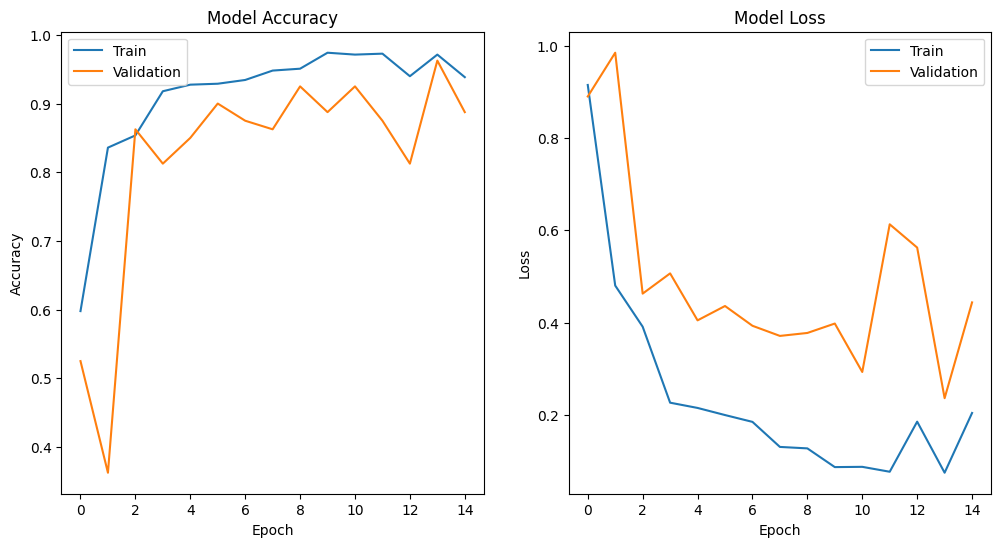

In [73]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [74]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

 3/36 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step
[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0
 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 2 2 2 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 0 2 2 0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [75]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.7651
Precision : 0.8376
Recall : 0.7651
F1 Score : 0.7678
Classification Report:
               precision    recall  f1-score   support

         car       0.96      0.61      0.75       147
         cat       0.56      0.97      0.71        70
         man       0.86      0.89      0.88        64

    accuracy                           0.77       281
   macro avg       0.79      0.82      0.78       281
weighted avg       0.84      0.77      0.77       281



In [76]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[90 48  9]
 [ 2 68  0]
 [ 2  5 57]]


Classification using Pre-Trained RESNET 50

In [80]:
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_resnet_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Load ResNet50 pretrained model
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Freeze base model layers
    if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False

    # Adding custom layers on top
    x = base_model.output
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)  
    output_layer = Dense(n_classes, activation='softmax')(x)
    
    # Final model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_resnet_model((300, 300, 3), 3, optimizer=Adam(learning_rate=0.0001), fine_tune=15)

# Print model summary
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 306, 306,  │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 150, 150,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 150, 150,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_3_c

 Total params: 128,447,363 (489.99 MB)

 Trainable params: 110,380,035 (421.07 MB)

 Non-trainable params: 18,067,328 (68.92 MB)

In [81]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 363ms/step - accuracy: 0.4231 - loss: 4.6037 - val_accuracy: 0.3500 - val_loss: 1.1133
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.5353 - loss: 0.9226 - val_accuracy: 0.3125 - val_loss: 1.9762
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 287ms/step - accuracy: 0.6081 - loss: 0.8564 - val_accuracy: 0.5125 - val_loss: 1.2653
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - accuracy: 0.7404 - loss: 0.6144 - val_accuracy: 0.5875 - val_loss: 0.8458
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 287ms/step - accuracy: 0.8144 - loss: 0.5429 - val_accuracy: 0.6000 - val_loss: 0.9817
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 0.8090 - loss: 0.5289 - val_accuracy: 0.3375 - val_loss: 5.2514
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 296ms/step - accuracy: 0.8235 - loss: 0.4734 - val_accuracy: 0.4000 - val_loss: 2.9495
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 285ms/step - accuracy: 0.8295 - loss: 0.4354 - val_accu

In [82]:
history_dict = history.history

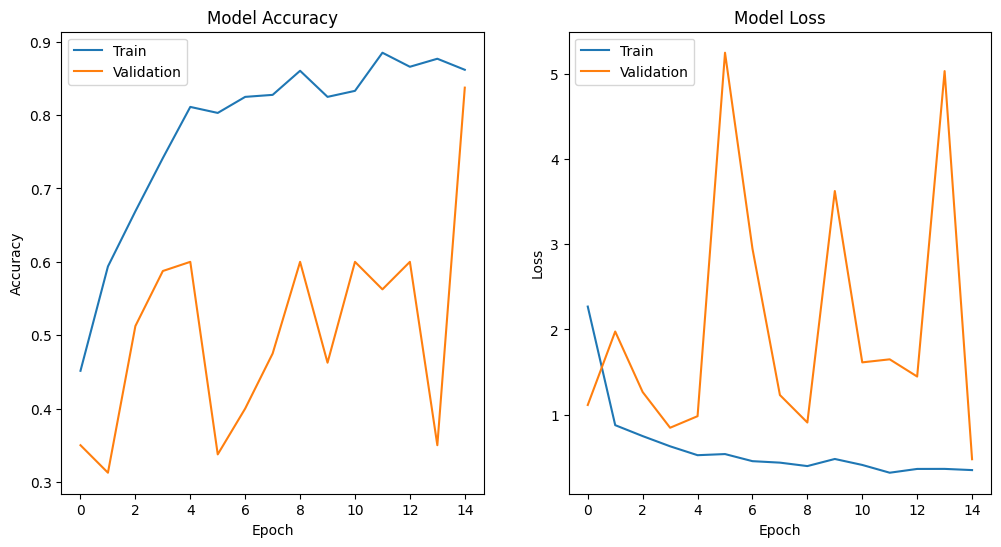

In [83]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [84]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 406ms/step
[0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 2 1
 1 0 1 2 1 2 2 1 2 2 1 2 1 1 1 1 1 2 2 1 2 1 1 2 2 2 1 2 2 1 2 2 2 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 1 2 1 0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [85]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.5943
Precision : 0.8097
Recall : 0.5943
F1 Score : 0.6029
Classification Report:
               precision    recall  f1-score   support

         car       0.93      0.52      0.66       147
         cat       0.39      0.99      0.56        70
         man       1.00      0.34      0.51        64

    accuracy                           0.59       281
   macro avg       0.77      0.62      0.58       281
weighted avg       0.81      0.59      0.60       281



In [86]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[76 71  0]
 [ 1 69  0]
 [ 5 37 22]]


Classification using single channel thermal images

Data Verification

In [43]:
import os

In [2]:
from PIL import Image # type: ignore

# Load the image
image = Image.open('/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Test/car/flir_20200116T174848.jpg')

# Get the mode of the image, which indicates the number of channels
print("Image mode:", image.mode)

# To get the number of channels directly
num_channels = len(image.getbands())
print("Number of channels:", num_channels)


Image mode: L
Number of channels: 1


In [3]:
import cv2 # type: ignore

# Load the image
image = cv2.imread('/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Test/car/flir_20200116T174848.jpg', -1)  # Load with all channels

# Get the shape of the image
print("Image shape:", image.shape)

# Number of channels is the last dimension
if len(image.shape) == 2:
    print("Number of channels: 1 (Grayscale)")
else:
    print(f"Number of channels: {image.shape[2]}")


Image shape: (640, 480)
Number of channels: 1 (Grayscale)


In [4]:
train_path='/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data4/singlech/thermal_output/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.jpg'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: car
Images: 250

class: cat
Images: 272

class: man
Images: 289

Test Data:
class: car
Images: 147

class: cat
Images: 70

class: man
Images: 64



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [5]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

2024-10-07 13:39:32.815216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 13:39:32.836771: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 13:39:32.843464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 13:39:32.859556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 13:39:33.902110: W tensorflow/comp

In [6]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.1)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='grayscale',
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='grayscale',
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='grayscale',
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 731 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 281 images belonging to 3 classes.
{'car': 0, 'cat': 1, 'man': 2}
731
{'car': 0, 'cat': 1, 'man': 2}
80
{'car': 0, 'cat': 1, 'man': 2}
281


Checking Shape of loaded data batches

In [7]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (8, 300, 300, 1), Labels shape: (8, 3)
Validation batch shape: (8, 300, 300, 1), Labels shape: (8, 3)
Test batch shape: (8, 300, 300, 1), Labels shape: (8, 3)


Define the CNN using MobileNet Backbone(using an additional input layer which converts single ch to three ch)

In [11]:
from tensorflow.keras.applications import MobileNet # type: ignore
from tensorflow.keras.models import Model # type: ignore # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, Input # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model_mobilenet(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Adjust input to single channel
    input_layer = Input(shape=input_shape)
    
    # Load MobileNet pretrained model
    conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))
    
    # Add a Conv2D layer to convert 1-channel input to 3-channel input expected by MobileNet
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    
    # Apply MobileNet
    x = conv_base(x)
    
    # Freezing layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding layers on top
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
    
    # Final model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Re-compile the model, with last 15 layers unfrozen for Fine-Tuning
model = create_model_mobilenet((300, 300, 1), 3, optimizer=Adam(), fine_tune=15)

# Print model summary
model.summary()


2024-10-07 11:22:29.162009: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9640 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5
/tmp/ipykernel_1260034/797173122.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 300, 300, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 9, 9, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    42,467,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,698,273 (174.33 MB)

 Trainable params: 44,064,289 (168.09 MB)

 Non-trainable params: 1,633,984 (6.23 MB)

In [33]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/92 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.5433 - loss: 38.6108

2024-10-07 08:50:37.484453: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 8 bytes spill stores, 8 bytes spill loads



92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.6742 - loss: 24.1355 - val_accuracy: 0.9375 - val_loss: 0.9573
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9463 - loss: 0.4070 - val_accuracy: 0.9750 - val_loss: 0.0647
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9518 - loss: 0.3599 - val_accuracy: 0.8875 - val_loss: 1.0249
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9603 - loss: 0.2311 - val_accuracy: 1.0000 - val_loss: 1.2719e-04
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9904 - loss: 0.0719 - val_accuracy: 0.9875 - val_loss: 0.0248
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9917 - loss: 0.0456 - val_accuracy: 0.9375 - val_loss: 0.1659
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9894 - loss: 0.0616 - val_accuracy: 0.7875 - val_loss: 2.2570
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.9906 - loss: 0.0233 - val_accuracy: 0.9125 - val_l

In [34]:
history_dict = history.history

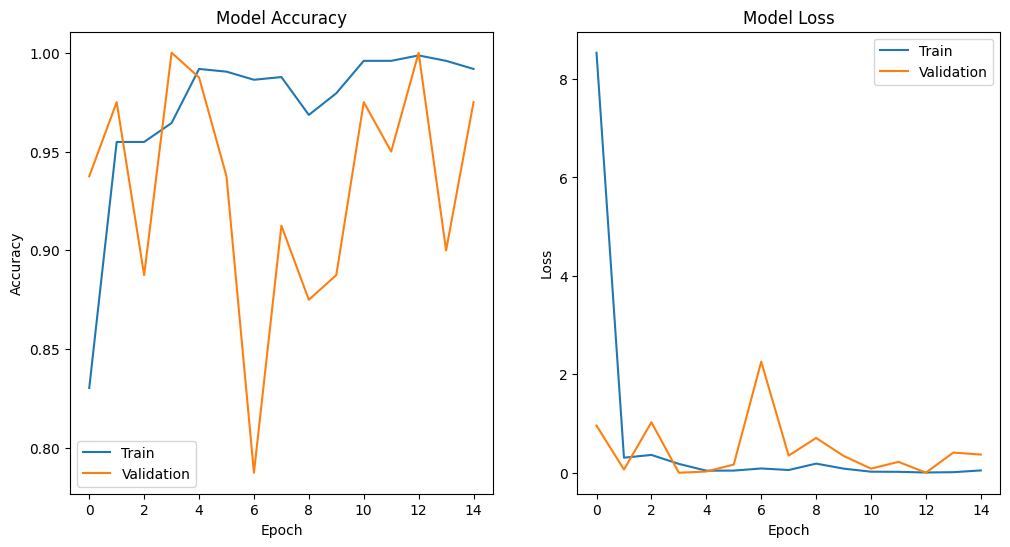

In [35]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [36]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [38]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9715
Precision : 0.9730
Recall : 0.9715
F1 Score : 0.9714
Classification Report:
               precision    recall  f1-score   support

         car       0.95      1.00      0.97       147
         cat       1.00      0.93      0.96        70
         man       1.00      0.95      0.98        64

    accuracy                           0.97       281
   macro avg       0.98      0.96      0.97       281
weighted avg       0.97      0.97      0.97       281



In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[147   0   0]
 [  5  65   0]
 [  3   0  61]]


Define the CNN using VGG16 Backbone

In [12]:
from tensorflow.keras.applications import VGG16 # type: ignore 
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, Input # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model_vgg16(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Adjust input to single channel
    input_layer = Input(shape=input_shape)
    
    # Load VGG16 pretrained model
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))
    
    # Add a Conv2D layer to convert 1-channel input to 3-channel input expected by VGG16
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    
    # Apply VGG16 backbone
    x = conv_base(x)
    
    # Freezing layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding layers on top of VGG16
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
    
    # Final model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Re-compile the model, with last 15 layers unfrozen for Fine-Tuning
model = create_model_vgg16((300, 300, 1), 3, optimizer=Adam(learning_rate=0.0001), fine_tune=10)

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300, 300, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 300, 300, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 9, 9, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,950,433 (137.14 MB)

 Trainable params: 34,805,025 (132.77 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [13]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15


/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728280411.274888 1260896 service.cc:146] XLA service 0x7f577400e170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728280411.274956 1260896 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-10-07 11:23:31.361882: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-07 11:23:31.775486: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907

 1/92 ━━━━━━━━━━━━━━━━━━━━ 17:46 12s/step - accuracy: 0.5000 - loss: 0.9967

I0000 00:00:1728280419.527844 1260896 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/92 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3594 - loss: 1.1685

2024-10-07 11:23:47.149178: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 11:23:47.370719: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 11:23:47.608078: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 11:23:47.975531: W external/local_tsl/tsl/framework/bfc_

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3948 - loss: 1.1240

2024-10-07 11:23:54.080354: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 11:23:54.590114: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 11:23:55.124689: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.3962 - loss: 1.1223 - val_accuracy: 0.5750 - val_loss: 0.8289
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.6990 - loss: 0.7247 - val_accuracy: 0.8625 - val_loss: 0.3443
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8864 - loss: 0.3419 - val_accuracy: 0.9375 - val_loss: 0.2036
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9184 - loss: 0.2668 - val_accuracy: 0.8375 - val_loss: 0.4144
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.9109 - loss: 0.2442 - val_accuracy: 0.8625 - val_loss: 0.3047
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9233 - loss: 0.2418 - val_accuracy: 0.8875 - val_loss: 0.2155
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9204 - loss: 0.1942 - val_accuracy: 0.9000 - val_loss: 0.2706
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.9531 - loss: 0.1419 - val_accuracy: 0.8875 - val_loss: 

In [14]:
history_dict = history.history

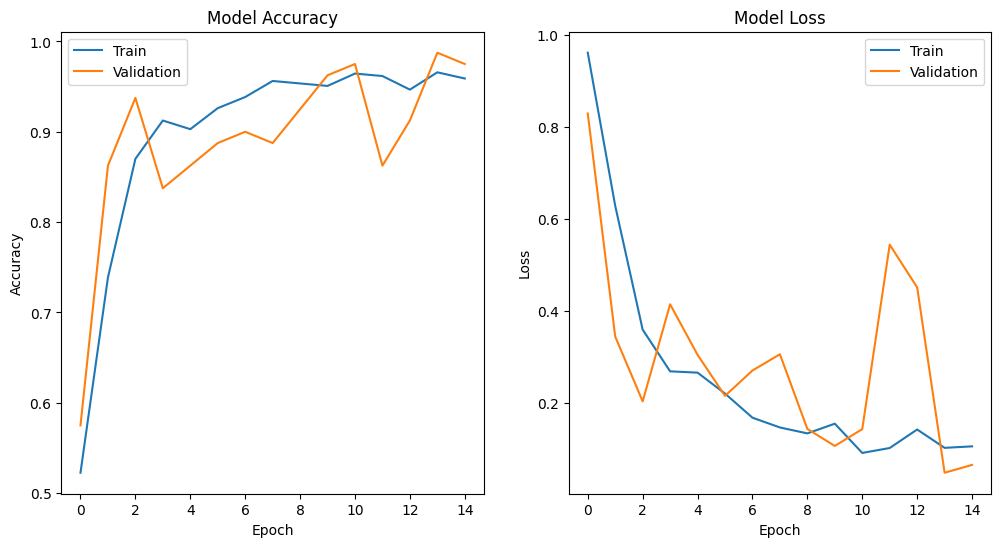

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [17]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 0 2 2
 0 1 0 0 0 0 0 0 2 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [18]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9110
Precision : 0.9301
Recall : 0.9110
F1 Score : 0.9143
Classification Report:
               precision    recall  f1-score   support

         car       1.00      0.87      0.93       147
         cat       0.96      0.93      0.94        70
         man       0.74      0.98      0.85        64

    accuracy                           0.91       281
   macro avg       0.90      0.93      0.91       281
weighted avg       0.93      0.91      0.91       281



In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[128   2  17]
 [  0  65   5]
 [  0   1  63]]


Define the CNN using RESNET 50 Backbone

In [12]:
from tensorflow.keras.applications import ResNet50  # type: ignore # Import ResNet50
from tensorflow.keras.models import Model # type: ignore  # Model class
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, Input # type: ignore  # Various layers
from tensorflow.keras.optimizers import Adam # type: ignore  # Adam optimizer

def create_model_resnet50(input_shape, n_classes, optimizer='adam', fine_tune=0):
    # Input layer for single-channel thermal images
    input_layer = Input(shape=input_shape)
    
    # Load ResNet50 pretrained model without the top layers
    conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))
    
    # Add a Conv2D layer to convert 1-channel input to 3-channel input expected by ResNet50
    x = Conv2D(3, (1, 1), padding='same')(input_layer)
    
    # Apply ResNet50
    x = conv_base(x)
    
    # Freezing layers for fine-tuning
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding custom classification layers on top
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)  
    output_layer = Dense(n_classes, activation='softmax')(x)
    
    # Final model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Example usage
model = create_model_resnet50((300, 300, 1), 3, optimizer=Adam(learning_rate=0.00001), fine_tune=10)

# Print model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 300, 300, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 300, 300, 3)    │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 10, 10, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │   104,858,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,447,369 (489.99 MB)

 Trainable params: 109,325,321 (417.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [13]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 166ms/step - accuracy: 0.3544 - loss: 1.7225 - val_accuracy: 0.3125 - val_loss: 1.1273
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.3757 - loss: 1.2466 - val_accuracy: 0.3125 - val_loss: 1.1589
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.3413 - loss: 1.1992 - val_accuracy: 0.3125 - val_loss: 1.1292
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.4223 - loss: 1.0847 - val_accuracy: 0.2375 - val_loss: 1.0993
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.3600 - loss: 1.1004 - val_accuracy: 0.4375 - val_loss: 1.0899
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.3697 - loss: 1.0909 - val_accuracy: 0.3500 - val_loss: 1.1107
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.4097 - loss: 1.0784 - val_accuracy: 0.2000 - val_loss: 1.1104
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.3865 - loss: 1.0837 - val_accuracy: 0.4000 -

In [14]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.7042 - loss: 0.6835 - val_accuracy: 0.5500 - val_loss: 0.7436
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.7576 - loss: 0.6005 - val_accuracy: 0.6625 - val_loss: 0.6790
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7729 - loss: 0.5802 - val_accuracy: 0.7625 - val_loss: 0.6125
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.7815 - loss: 0.5721 - val_accuracy: 0.7625 - val_loss: 0.5359
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.7852 - loss: 0.5792 - val_accuracy: 0.6375 - val_loss: 0.6635
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.8052 - loss: 0.5166 - val_accuracy: 0.7875 - val_loss: 0.5980
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8068 - loss: 0.5038 - val_accuracy: 0.6500 - val_loss: 0.6803
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8079 - loss: 0.5212 - val_accuracy: 0.7000 - v

In [15]:
history_dict = history.history

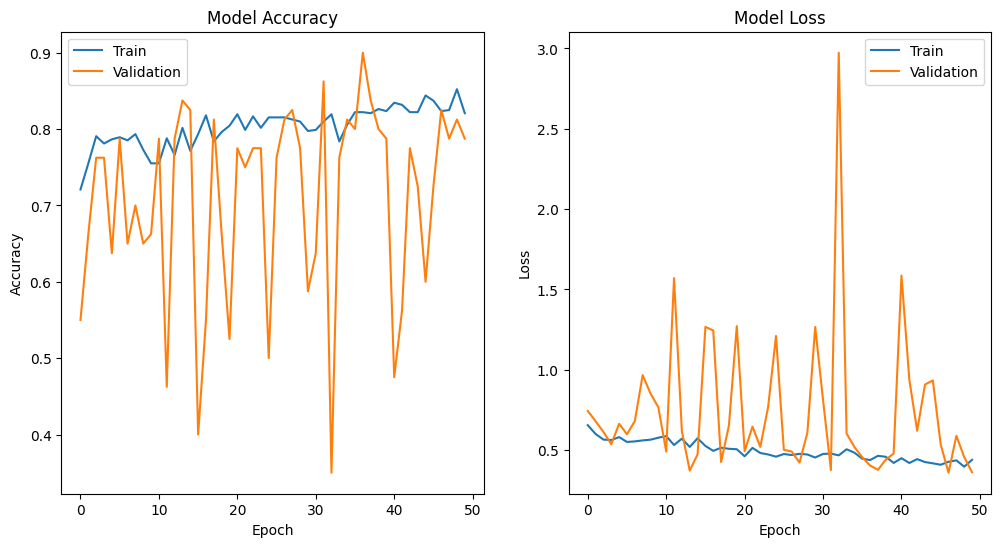

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [17]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step
[0 0 1 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0 0
 0 0 0 2 0 0 0 0 2 0 1 0 1 2 0 1 1 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1
 0 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 1 1 1 2 1 2 2 2 1 1 0 2 1 1 1 2 2 2
 1 1 1 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 1 1 1 2 2 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 2 2 2 0 0 2 2 2 2 0 2 2 2 1 2 1 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [18]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.7509
Precision : 0.7971
Recall : 0.7509
F1 Score : 0.7570
Classification Report:
               precision    recall  f1-score   support

         car       0.95      0.78      0.86       147
         cat       0.70      0.54      0.61        70
         man       0.55      0.91      0.68        64

    accuracy                           0.75       281
   macro avg       0.73      0.74      0.72       281
weighted avg       0.80      0.75      0.76       281



In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[115  14  18]
 [  2  38  30]
 [  4   2  58]]


Classification using 4 channel images with camera output and thermal data

Data Verification

In [15]:
import os

In [16]:
from PIL import Image # type: ignore

# Load the image
image = Image.open('/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Test/cat/flir_20200203T125735.png')

# Get the mode of the image, which indicates the number of channels
print("Image mode:", image.mode)

# To get the number of channels directly
num_channels = len(image.getbands())
print("Number of channels:", num_channels)


Image mode: RGBA
Number of channels: 4


In [17]:
import cv2 # type: ignore

# Load the image
image = cv2.imread('/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Test/cat/flir_20200203T125735.png', -1)  # Load with all channels

# Get the shape of the image
print("Image shape:", image.shape)

# Number of channels is the last dimension
if len(image.shape) == 2:
    print("Number of channels: 1 (Grayscale)")
else:
    print(f"Number of channels: {image.shape[2]}")


Image shape: (640, 480, 4)
Number of channels: 4


In [18]:
train_path='/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Train'
#valid_path='/home/deepaksr/project/project_assignment1/data/valid'
test_path='/home/deepaksr/project/project_assignment1/data4/thermal_rgba_png_output/Test'
def verify_data(folder):
  for classes in os.listdir(folder):
    class_path=os.path.join(folder,classes)
    if os.path.isdir(class_path):
      images = [i for i in os.listdir(class_path) if os.path.isfile(os.path.join(class_path,i))]
      counter = sum(1 for image in images if image.lower().endswith('.png'))
      print(f'class: {classes}')
      print(f'Images: {counter}\n')

print('Training Data:')
verify_data(train_path)
#print('Validation Data:')
#verify_data(valid_path)
print('Test Data:')
verify_data(test_path)

Training Data:
class: car
Images: 250

class: cat
Images: 272

class: man
Images: 289

Test Data:
class: car
Images: 147

class: cat
Images: 70

class: man
Images: 64



Data Augmentation using ImageDataGenerator & Data Generator using flow_from_directory 
(https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)

In [19]:
import keras # type: ignore
import tensorflow as tf # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [20]:
datagen= ImageDataGenerator(rotation_range=10,width_shift_range=0.05,height_shift_range=0.05,
                            horizontal_flip=True, rescale=1.0/255, validation_split=0.1)
train_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='rgba',
                                            shuffle=True, subset='training')
val_generator = datagen.flow_from_directory(directory=train_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='rgba',
                                            shuffle=True, subset='validation')
test_generator = datagen.flow_from_directory(directory=test_path,
                                            target_size=(300,300),
                                            class_mode='categorical',
                                            batch_size=8,
                                            color_mode='rgba',
                                            shuffle=False)

print(train_generator.class_indices)
print(train_generator.samples)
print(val_generator.class_indices)
print(val_generator.samples)
print(test_generator.class_indices)
print(test_generator.samples)

Found 731 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 281 images belonging to 3 classes.
{'car': 0, 'cat': 1, 'man': 2}
731
{'car': 0, 'cat': 1, 'man': 2}
80
{'car': 0, 'cat': 1, 'man': 2}
281


Checking Shape of loaded data batches

In [21]:
x_train_batch, y_train_batch = next(train_generator)
x_valid_batch, y_valid_batch = next(val_generator)
x_test_batch, y_test_batch = next(test_generator)

print(f"Training batch shape: {x_train_batch.shape}, Labels shape: {y_train_batch.shape}")
print(f"Validation batch shape: {x_valid_batch.shape}, Labels shape: {y_valid_batch.shape}")
print(f"Test batch shape: {x_test_batch.shape}, Labels shape: {y_test_batch.shape}")

Training batch shape: (8, 300, 300, 4), Labels shape: (8, 3)
Validation batch shape: (8, 300, 300, 4), Labels shape: (8, 3)
Test batch shape: (8, 300, 300, 4), Labels shape: (8, 3)


Define the CNN using MobileNet Backbone(using an additional input layer which converts four ch to three ch)

In [22]:
from tensorflow.keras.applications import MobileNet # type: ignore
from tensorflow.keras.models import Model # type: ignore # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, Input # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model_mobilenet(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Adjust input to single channel
    input_layer = Input(shape=input_shape)
    
    # Load MobileNet pretrained model
    conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))
    
    # Add a Conv2D layer to convert 1-channel input to 3-channel input expected by MobileNet
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    
    # Apply MobileNet
    x = conv_base(x)
    
    # Freezing layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding layers on top
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
    
    # Final model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Re-compile the model, with last 15 layers unfrozen for Fine-Tuning
model = create_model_mobilenet((300, 300, 4), 3, optimizer=Adam(), fine_tune=15)

# Print model summary
model.summary()


/tmp/ipykernel_1278803/2442866481.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNet(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 300, 300, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 300, 300, 3)    │           111 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 9, 9, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    42,467,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,698,354 (174.33 MB)

 Trainable params: 44,064,370 (168.09 MB)

 Non-trainable params: 1,633,984 (6.23 MB)

In [23]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15


E0000 00:00:1728287059.485647 1279498 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728287059.610038 1279498 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


24/92 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.5608 - loss: 33.2930

E0000 00:00:1728287071.667276 1279500 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728287071.785355 1279500 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


27/92 ━━━━━━━━━━━━━━━━━━━━ 30s 464ms/step - accuracy: 0.5812 - loss: 32.1075

2024-10-07 13:14:36.375814: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 8 bytes spill stores, 8 bytes spill loads



92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 351ms/step - accuracy: 0.7544 - loss: 19.7632 - val_accuracy: 0.3125 - val_loss: 212.9813
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 261ms/step - accuracy: 0.9520 - loss: 4.4561 - val_accuracy: 0.5625 - val_loss: 24.1421
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 267ms/step - accuracy: 0.9691 - loss: 1.1091 - val_accuracy: 0.6750 - val_loss: 29.1873
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 268ms/step - accuracy: 0.9880 - loss: 0.3675 - val_accuracy: 0.6875 - val_loss: 33.2919
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9638 - loss: 1.3161 - val_accuracy: 0.7500 - val_loss: 25.1115
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 265ms/step - accuracy: 0.9755 - loss: 0.9433 - val_accuracy: 0.7500 - val_loss: 10.7081
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.9844 - loss: 0.8478 - val_accuracy: 0.8250 - val_loss: 21.2871
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 268ms/step - accuracy: 0.9876 - loss: 0.2546 - val_accura

In [24]:
history_dict = history.history

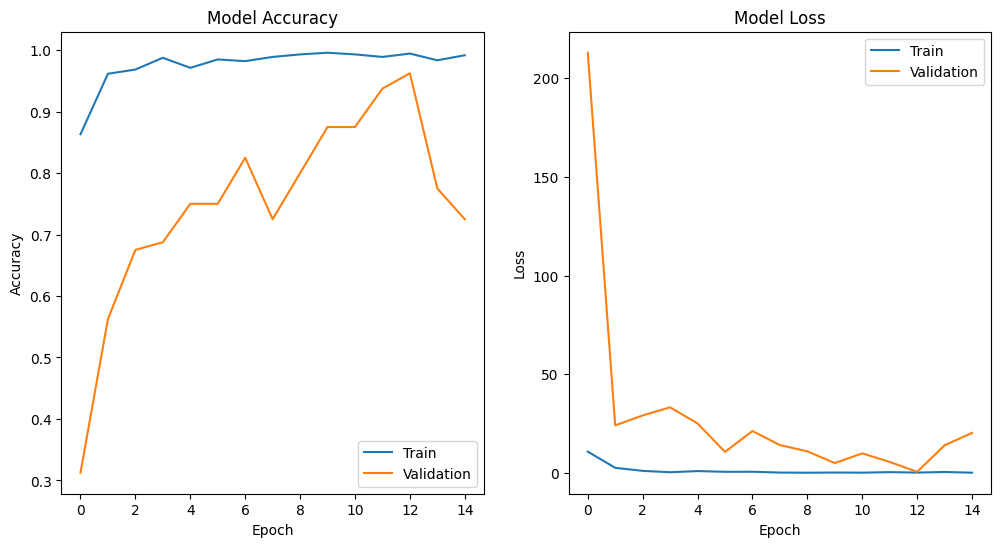

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [26]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

/home/deepaksr/miniconda3/envs/cnn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step

E0000 00:00:1728287480.213894 1279499 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728287480.336331 1279499 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1728287480.453587 1279499 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 318ms/step
[0 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 0 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [27]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9502
Precision : 0.9580
Recall : 0.9502
F1 Score : 0.9512
Classification Report:
               precision    recall  f1-score   support

         car       1.00      0.91      0.95       147
         cat       0.99      0.99      0.99        70
         man       0.83      1.00      0.91        64

    accuracy                           0.95       281
   macro avg       0.94      0.97      0.95       281
weighted avg       0.96      0.95      0.95       281



In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[134   1  12]
 [  0  69   1]
 [  0   0  64]]


Define the CNN using VGG16 Backbone

In [29]:
from tensorflow.keras.applications import VGG16 # type: ignore 
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, Input # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def create_model_vgg16(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    # Adjust input to single channel
    input_layer = Input(shape=input_shape)
    
    # Load VGG16 pretrained model
    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))
    
    # Add a Conv2D layer to convert 1-channel input to 3-channel input expected by VGG16
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    
    # Apply VGG16 backbone
    x = conv_base(x)
    
    # Freezing layers
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding layers on top of VGG16
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
    
    # Final model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Re-compile the model, with last 15 layers unfrozen for Fine-Tuning
model = create_model_vgg16((300, 300, 4), 3, optimizer=Adam(learning_rate=0.0001), fine_tune=10)

# Print model summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 300, 300, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 300, 300, 3)    │           111 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 9, 9, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,950,514 (137.14 MB)

 Trainable params: 34,805,106 (132.77 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [30]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15


2024-10-07 13:21:30.357616: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 13:21:30.475030: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 13:21:30.682567: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-07 13:21:30.797685: W external/local_tsl/tsl/framework/bfc_

23/92 ━━━━━━━━━━━━━━━━━━━━ 17s 253ms/step - accuracy: 0.3856 - loss: 1.3622

2024-10-07 13:21:41.898172: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 357ms/step - accuracy: 0.5776 - loss: 0.9660 - val_accuracy: 0.7875 - val_loss: 0.3762
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - accuracy: 0.8883 - loss: 0.3040 - val_accuracy: 0.8750 - val_loss: 0.2445
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 275ms/step - accuracy: 0.9452 - loss: 0.1413 - val_accuracy: 0.9375 - val_loss: 0.2487
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - accuracy: 0.9283 - loss: 0.2093 - val_accuracy: 0.7625 - val_loss: 0.7151
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 275ms/step - accuracy: 0.9706 - loss: 0.0797 - val_accuracy: 0.6875 - val_loss: 0.8430
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 273ms/step - accuracy: 0.9757 - loss: 0.0623 - val_accuracy: 0.7250 - val_loss: 0.7417
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - accuracy: 0.9332 - loss: 0.2140 - val_accuracy: 0.8625 - val_loss: 0.4886
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - accuracy: 0.9634 - loss: 0.1138 - val_accuracy: 0.950

In [31]:
history_dict = history.history

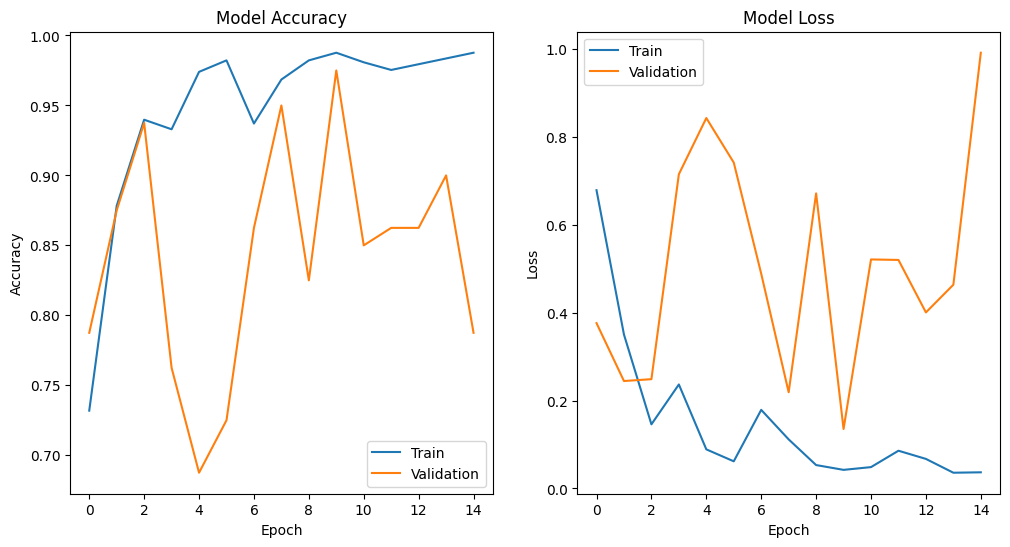

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [33]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [34]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.9680
Precision : 0.9703
Recall : 0.9680
F1 Score : 0.9683
Classification Report:
               precision    recall  f1-score   support

         car       0.99      0.97      0.98       147
         cat       1.00      0.94      0.97        70
         man       0.90      1.00      0.95        64

    accuracy                           0.97       281
   macro avg       0.96      0.97      0.96       281
weighted avg       0.97      0.97      0.97       281



In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[142   0   5]
 [  2  66   2]
 [  0   0  64]]


Define the CNN using RESNET 50 Backbone

In [36]:
from tensorflow.keras.applications import ResNet50  # type: ignore # Import ResNet50
from tensorflow.keras.models import Model  # type: ignore # Model class
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, Input  # type: ignore # Various layers
from tensorflow.keras.optimizers import Adam  # type: ignore # Adam optimizer

def create_model_resnet50(input_shape, n_classes, optimizer='adam', fine_tune=0):
    # Input layer for single-channel thermal images
    input_layer = Input(shape=input_shape)
    
    # Load ResNet50 pretrained model without the top layers
    conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))
    
    # Add a Conv2D layer to convert 1-channel input to 3-channel input expected by ResNet50
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    
    # Apply ResNet50
    x = conv_base(x)
    
    # Freezing layers for fine-tuning
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Adding custom classification layers on top
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Increased dropout for better generalization
    output_layer = Dense(n_classes, activation='softmax')(x)
    
    # Final model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Example usage
model = create_model_resnet50((300, 300, 4), 3, optimizer=Adam(learning_rate=0.0001), fine_tune=10)

# Print model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 300, 300, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 300, 300, 3)    │           111 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 10, 10, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │   104,858,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,447,474 (489.99 MB)

 Trainable params: 109,325,426 (417.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [37]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 365ms/step - accuracy: 0.3946 - loss: 5.7949 - val_accuracy: 0.3125 - val_loss: 1.0769
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.5227 - loss: 0.9250 - val_accuracy: 0.3250 - val_loss: 1.1287
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - accuracy: 0.6205 - loss: 0.8575 - val_accuracy: 0.4500 - val_loss: 1.1004
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - accuracy: 0.6595 - loss: 0.7572 - val_accuracy: 0.5875 - val_loss: 0.9237
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 0.6859 - loss: 0.6799 - val_accuracy: 0.6875 - val_loss: 0.5964
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - accuracy: 0.7520 - loss: 0.6357 - val_accuracy: 0.8125 - val_loss: 0.4277
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - accuracy: 0.8194 - loss: 0.4658 - val_accuracy: 0.6750 - val_loss: 0.7018
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 279ms/step - accuracy: 0.7604 - loss: 0.5912 - val_accu

In [38]:
history_dict = history.history

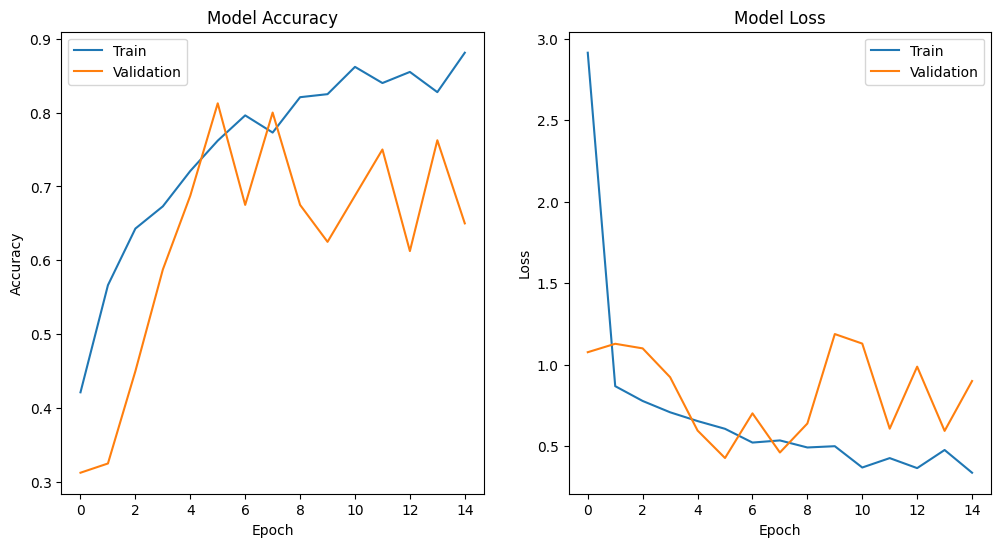

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Obtaining Predictions for testing & evaluation

In [40]:
import numpy as np
y_pred_prob=model.predict(test_generator)
y_pred=np.argmax(y_pred_prob, axis=1)
print(y_pred)
y_true=test_generator.classes
y_true

36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 0 2 2 2]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [41]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(y_true,y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall : {recall:.4f}')
print(f'F1 Score : {f1:.4f}')
print('Classification Report:\n', classification_report(y_true, y_pred,target_names=test_generator.class_indices.keys()))


Accuracy : 0.8577
Precision : 0.8775
Recall : 0.8577
F1 Score : 0.8489
Classification Report:
               precision    recall  f1-score   support

         car       0.80      0.97      0.88       147
         cat       0.97      0.56      0.71        70
         man       0.95      0.92      0.94        64

    accuracy                           0.86       281
   macro avg       0.91      0.82      0.84       281
weighted avg       0.88      0.86      0.85       281



In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[143   1   3]
 [ 31  39   0]
 [  5   0  59]]
